In [137]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import pyranges as pr

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from proc_revisions.utils import *
from proc_revisions.plotting import *
from proc_revisions.ss_sj_utils import *
from proc_revisions.extra_simplex_plots import *

In [138]:
od = '../../proc_revisions/'
config_file = f'{od}/config.yml'
with open(config_file) as f:
    config = yaml.safe_load(f)

In [139]:
species = 'human'
ab = od+expand(config['lr']['talon']['fusion_fix']['ab'], species='human')[0]
filt_ab = od+expand(config['lr']['cerberus']['filt_ab'], species=species)[0]
gtf = od+expand(config['lr']['cerberus']['gtf'], species=species)[0]
lib_meta = od+expand(config['lr']['meta'], species=species)[0]
cerberus_h5 = od+expand(config['lr']['cerberus']['ca_triplets'], species=species, obs_col='sample')[0]
swan_file = od+expand(config['lr']['swan']['sg'], species=species)[0]
ref_gtf = od+expand(config['ref']['new_gtf'], species=species)[0]
pp_summary = od+expand(config['lr']['protein_pred']['summary'], species='human')[0]
gtf_file = od+expand(config['lr']['cerberus']['gtf'], species='human')[0]

gtex_gtf_file = od+expand(config['gtex']['gtf'], species='human')[0]

gene_subset = 'polya'
min_tpm = 1

species = 'mouse'
m_filt_ab = od+expand(config['lr']['cerberus']['filt_ab'], species=species)[0]
m_gtf = od+expand(config['lr']['cerberus']['gtf'], species=species)[0]
m_lib_meta = od+expand(config['lr']['meta'], species=species)[0]
m_cerberus_h5 = od+expand(config['lr']['cerberus']['ca_triplets'], species=species, obs_col='sample')[0]
m_swan_file = od+expand(config['lr']['swan']['sg'], species=species)[0]
m_ref_gtf = od+expand(config['ref']['new_gtf'], species=species)[0]


## Get the parents of readthrough genes

In [4]:
# get expressed novel genes
df = pd.read_csv(filt_ab, sep='\t')
df, tids = get_tpm_table(df, 
                      how='iso',
                      min_tpm=0,
                      gene_subset=None)

df.reset_index(inplace=True)
df['gid'] = df.annot_transcript_id.str.split('[', expand=True)[0]
df.head()
df.reset_index(inplace=True)
df.rename({'gid_stable':'gid'}, axis=1, inplace=True)
ab_df = pd.read_csv(filt_ab, sep='\t')
ab_df['gid'] = ab_df.annot_transcript_id.str.split('[', expand=True)[0]
ab_df = ab_df[['gid', 'gene_novelty']].drop_duplicates()
ab_df.loc[ab_df.gid.duplicated(keep=False)].sort_values(by='gid')
assert len(ab_df.loc[ab_df.gid.duplicated(keep=False)].index) == 0
df = df.merge(ab_df, how='left', on='gid')
df.loc[df.gene_novelty=='Fusion', 'gene_novelty'] = 'Readthrough'

# sum up expression across gids
df.drop('annot_transcript_id', axis=1, inplace=True)
df = df.groupby(['gid', 'gene_novelty']).sum().reset_index()
df.drop('index', axis=1, inplace=True)

# get max tpm / gene
datasets = get_datasets('human')
df['max_tpm'] = df[datasets].max(axis=1)
df.drop(datasets, axis=1, inplace=True)

# add biotypes
gtf_df, _, _ = get_gtf_info(ver='v40_cerberus', how='gene')
gtf_df['gid_stable'] = cerberus.get_stable_gid(gtf_df, col='gid')
gtf_df = gtf_df[['gid_stable', 'biotype_category']]
df = df.merge(gtf_df, how='left', left_on='gid', right_on='gid_stable')

# keep only known / novel read through
rt_df, _, _ = get_gtf_info(ver='v40_cerberus', how='iso')
rt_df['gid_stable'] = cerberus.get_stable_gid(rt_df, 'gid')
rt_df = rt_df.loc[rt_df.readthrough_transcript==True]
known_rt_gids = rt_df.gid_stable.unique().tolist()
df['gene_status'] = False
df.loc[df.gid.isin(known_rt_gids), 'gene_status'] = 'Known\nreadthrough'
df.loc[df.gene_novelty=='Readthrough', 'gene_status'] = 'Novel\nreadthrough'
df = df.loc[df.gene_status != False]
df[['gid', 'gene_status']].groupby('gene_status').nunique().reset_index()
rt_gids = df.gid.tolist()

Calculating iso TPM values


/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2110: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2109: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Number of isos reported: 236615


In [5]:
tid_df = pd.DataFrame()
tid_df['tid'] = tids
tid_df = add_feat(tid_df, kind='ic', col='tid')
tid_df.head()
exp_ics = tid_df.ic.unique().tolist()

In [6]:
# # keep only known / novel read through
# rt_df, _, _ = get_gtf_info(ver='v40_cerberus', how='iso')
# rt_df['gid_stable'] = cerberus.get_stable_gid(rt_df, 'gid')
# rt_df = rt_df.loc[rt_df.readthrough_transcript==True]
# known_rt_gids = rt_df.gid_stable.unique().tolist()
# df['gene_status'] = False
# df.loc[df.gid.isin(known_rt_gids), 'gene_status'] = 'Known\nreadthrough'
# df.loc[df.gene_novelty=='Readthrough', 'gene_status'] = 'Novel\nreadthrough'
# df = df.loc[df.gene_status != False]
# df[['gid', 'gene_status']].groupby('gene_status').nunique().reset_index()
# rt_gids = df.gid.tolist()

In [7]:
rt_gids = df.gid.tolist()
df.head()
len(df.index)

# get the sjs
ref_sources = ['v29', 'v40']
ca = cerberus.read(cerberus_h5)
sj_df, sj_ic_df = get_ss_from_ic(ca.ic, ref_sources)

# get the sj IDs
sj_df['sj_id'] = sj_df['Chromosome']+'_'+\
                 sj_df['Strand']+'_'+\
                 sj_df['Start'].astype(str)+'_'+\
                 sj_df['ss_type'].astype(str)

# get the sj IDs
sj_ic_df['sj_id'] = sj_ic_df['Chromosome']+'_'+\
                 sj_ic_df['Strand']+'_'+\
                 sj_ic_df['Start'].astype(str)+'_'+\
                 sj_ic_df['ss_type'].astype(str)
# sj_df.head()

# # limit to ics from expressed isoforms
print(len(sj_ic_df.sj_id.unique().tolist()))
sj_ids = sj_ic_df.loc[sj_ic_df.Name.isin(exp_ics), 'sj_id'].unique()
print(len(sj_ids))

print(len(sj_df.index))
sj_df = sj_df.loc[sj_df.sj_id.isin(sj_ids)]
print(len(sj_df.index))

# assert len(sj_df.loc[sj_df.Start>sj_df.End].index) == 0

# overlap sjs from readthrough genes
rt_sj_df = sj_df.loc[sj_df.gene_id.isin(rt_gids)]
print(len(rt_sj_df.gene_id.unique()))

# other, non rt genes
other_sj_df = sj_df.loc[~sj_df.gene_id.isin(rt_gids)]

# merge
rt_sj_df = rt_sj_df.merge(other_sj_df,
                          how='left',
                          on='sj_id',
                          suffixes=('', '_parent'))

631586
410797
659663
434554
430


In [9]:
sj_df.head()

,Chromosome,Strand,gene_id,Start,ss_type,source,novelty,sj_id
192,chr1,+,ENSG00000000460,169795115.0,ss_5,"v40,v29,lapa",Known,chr1_+_169795115.0_ss_5
193,chr1,+,ENSG00000000460,169795213.0,ss_5,"v40,v29,lapa,gtex",Known,chr1_+_169795213.0_ss_5
194,chr1,+,ENSG00000000460,169795226.0,ss_5,lapa,Novel,chr1_+_169795226.0_ss_5
195,chr1,+,ENSG00000000460,169795828.0,ss_3,"v40,v29,lapa,gtex",Known,chr1_+_169795828.0_ss_3
196,chr1,+,ENSG00000000460,169795983.0,ss_5,"v40,v29,lapa,gtex",Known,chr1_+_169795983.0_ss_5


In [10]:
# limit to entries that intersect
print(len(rt_sj_df.index))
rt_sj_df = rt_sj_df.loc[rt_sj_df.gene_id_parent.notnull()]
print(len(rt_sj_df.index))

9182
8229


In [11]:
# get 5' and 3' most coords for each gene
rt_sj_df = rt_sj_df.merge(rt_sj_df[['gene_id', 'Start', 'Start_parent']].groupby('gene_id').agg(min_coord=('Start', np.min),
                                                                                   max_coord=('Start', np.max),
                                                                                   min_coord_parent=('Start_parent', np.min),
                                                                                   max_coord_parent=('Start_parent', np.max)).reset_index(),
                  how='left',
                  on='gene_id')
rt_sj_df.head()

,Chromosome,Strand,gene_id,Start,ss_type,source,novelty,sj_id,Chromosome_parent,Strand_parent,gene_id_parent,Start_parent,ss_type_parent,source_parent,novelty_parent,min_coord,max_coord,min_coord_parent,max_coord_parent
0,chr1,+,ENSG00000120948,11012743.0,ss_5,"v40,v29,lapa,gtex",Known,chr1_+_11012743.0_ss_5,chr1,+,ENSG00000277726,11012743.0,ss_5,"v29,gtex",Known,11012743.0,11029901.0,11012743.0,11029901.0
1,chr1,+,ENSG00000120948,11013715.0,ss_3,"v40,v29,lapa,gtex",Known,chr1_+_11013715.0_ss_3,chr1,+,ENSG00000277726,11013715.0,ss_3,"v29,gtex",Known,11012743.0,11029901.0,11012743.0,11029901.0
2,chr1,+,ENSG00000120948,11013965.0,ss_5,"v40,v29,lapa,gtex",Known,chr1_+_11013965.0_ss_5,chr1,+,ENSG00000277726,11013965.0,ss_5,"v29,gtex",Known,11012743.0,11029901.0,11012743.0,11029901.0
3,chr1,+,ENSG00000120948,11016843.0,ss_3,"v40,v29,lapa,gtex",Known,chr1_+_11016843.0_ss_3,chr1,+,ENSG00000277726,11016843.0,ss_3,"v29,gtex",Known,11012743.0,11029901.0,11012743.0,11029901.0
4,chr1,+,ENSG00000120948,11017007.0,ss_5,"v40,v29,lapa,gtex",Known,chr1_+_11017007.0_ss_5,chr1,+,ENSG00000277726,11017007.0,ss_5,"v29,gtex",Known,11012743.0,11029901.0,11012743.0,11029901.0


In [12]:
# get dist to each parent coord
rt_sj_df['min_coord_dist'] = (rt_sj_df['Start']-rt_sj_df['min_coord_parent']).abs()
rt_sj_df['max_coord_dist'] = (rt_sj_df['Start']-rt_sj_df['max_coord_parent']).abs()
rt_sj_df.gene_id.unique().tolist()[:5]

['ENSG00000120948',
 'ENSG00000237188',
 'ENSG00000251246',
 'ENSG00000251503',
 'ENSG00000259030']

In [13]:
# # get ID of gene w/ min and max dists
# rt_sj_df = rt_sj_df.merge(rt_sj_df[['gene_id', 'gene_id_parent',
#                                     'min_coord_dist', 'max_coord_dist']].groupby('gene_id').agg()

In [14]:
# rt_sj_df.loc[rt_sj_df.gene_id=='ENSG00000259030'][['gene_id', 'min_coord', 'max_coord', 'gene_id_parent', 'min_coord_parent', 'max_coord_parent', 'min_coord_dist', 'max_coord_dist']]

In [15]:
# Group by 'gene_id' and find the index of the minimum 'min_coord_dist' and 'max_coord_dist' in each group
idx_min_dist = rt_sj_df.groupby('gene_id')['min_coord_dist'].idxmin()
idx_min_max_dist = rt_sj_df.groupby('gene_id')['max_coord_dist'].idxmin()

# Use the indices to get the corresponding 'gene_id_parent' values for both columns
result_min_dist_df = rt_sj_df.loc[idx_min_dist, ['gene_id', 'gene_id_parent', 'min_coord_dist']].rename({'gene_id_parent':'gene_id_parent_min',
                                                                                                     'min_coord_dist':'min_min_coord_dist'}, axis=1)
result_min_max_dist_df = rt_sj_df.loc[idx_min_max_dist, ['gene_id', 'gene_id_parent', 'max_coord_dist']].rename({'gene_id_parent':'gene_id_parent_max',
                                                                                                             'max_coord_dist':'min_max_coord_dist'}, axis=1)
# Merge the two results on 'gene_id' for a complete result
result_df = pd.merge(result_min_dist_df, result_min_max_dist_df, on='gene_id')
result_df.head()

,gene_id,gene_id_parent_min,min_min_coord_dist,gene_id_parent_max,min_max_coord_dist
0,ENSG00000006194,ENSG00000281005,0.0,ENSG00000281005,0.0
1,ENSG00000011052,ENSG00000239672,0.0,ENSG00000243678,0.0
2,ENSG00000063978,ENSG00000125386,0.0,ENSG00000125386,0.0
3,ENSG00000064489,ENSG00000213999,0.0,ENSG00000213999,0.0
4,ENSG00000085514,ENSG00000242294,0.0,ENSG00000289690,0.0


In [16]:
# merge in gene ids w/ min and max values
rt_sj_df = rt_sj_df.merge(result_df, how='left',
                          on='gene_id')
rt_sj_df.head()

,Chromosome,Strand,gene_id,Start,ss_type,source,novelty,sj_id,Chromosome_parent,Strand_parent,...,min_coord,max_coord,min_coord_parent,max_coord_parent,min_coord_dist,max_coord_dist,gene_id_parent_min,min_min_coord_dist,gene_id_parent_max,min_max_coord_dist
0,chr1,+,ENSG00000120948,11012743.0,ss_5,"v40,v29,lapa,gtex",Known,chr1_+_11012743.0_ss_5,chr1,+,...,11012743.0,11029901.0,11012743.0,11029901.0,0.0,17158.0,ENSG00000277726,0.0,ENSG00000271895,0.0
1,chr1,+,ENSG00000120948,11013715.0,ss_3,"v40,v29,lapa,gtex",Known,chr1_+_11013715.0_ss_3,chr1,+,...,11012743.0,11029901.0,11012743.0,11029901.0,972.0,16186.0,ENSG00000277726,0.0,ENSG00000271895,0.0
2,chr1,+,ENSG00000120948,11013965.0,ss_5,"v40,v29,lapa,gtex",Known,chr1_+_11013965.0_ss_5,chr1,+,...,11012743.0,11029901.0,11012743.0,11029901.0,1222.0,15936.0,ENSG00000277726,0.0,ENSG00000271895,0.0
3,chr1,+,ENSG00000120948,11016843.0,ss_3,"v40,v29,lapa,gtex",Known,chr1_+_11016843.0_ss_3,chr1,+,...,11012743.0,11029901.0,11012743.0,11029901.0,4100.0,13058.0,ENSG00000277726,0.0,ENSG00000271895,0.0
4,chr1,+,ENSG00000120948,11017007.0,ss_5,"v40,v29,lapa,gtex",Known,chr1_+_11017007.0_ss_5,chr1,+,...,11012743.0,11029901.0,11012743.0,11029901.0,4264.0,12894.0,ENSG00000277726,0.0,ENSG00000271895,0.0


In [17]:
# rt_sj_df.loc[rt_sj_df.gene_id_pare

In [18]:
rt_sj_df.loc[rt_sj_df.gene_id_parent == 'ENSG00000243364']


,Chromosome,Strand,gene_id,Start,ss_type,source,novelty,sj_id,Chromosome_parent,Strand_parent,...,min_coord,max_coord,min_coord_parent,max_coord_parent,min_coord_dist,max_coord_dist,gene_id_parent_min,min_min_coord_dist,gene_id_parent_max,min_max_coord_dist
66,chr1,+,ENSG00000251246,155063936.0,ss_5,"v40,v29,lapa",Known,chr1_+_155063936.0_ss_5,chr1,+,...,155063936.0,155086412.0,155063936.0,155086412.0,0.0,22476.0,ENSG00000243364,0.0,ENSG00000143590,0.0


In [19]:
rt_sj_df.loc[rt_sj_df.gene_id_parent_min!=rt_sj_df.gene_id_parent_max]

,Chromosome,Strand,gene_id,Start,ss_type,source,novelty,sj_id,Chromosome_parent,Strand_parent,...,min_coord,max_coord,min_coord_parent,max_coord_parent,min_coord_dist,max_coord_dist,gene_id_parent_min,min_min_coord_dist,gene_id_parent_max,min_max_coord_dist
0,chr1,+,ENSG00000120948,11012743.0,ss_5,"v40,v29,lapa,gtex",Known,chr1_+_11012743.0_ss_5,chr1,+,...,11012743.0,11029901.0,11012743.0,11029901.0,0.0,17158.0,ENSG00000277726,0.0,ENSG00000271895,0.0
1,chr1,+,ENSG00000120948,11013715.0,ss_3,"v40,v29,lapa,gtex",Known,chr1_+_11013715.0_ss_3,chr1,+,...,11012743.0,11029901.0,11012743.0,11029901.0,972.0,16186.0,ENSG00000277726,0.0,ENSG00000271895,0.0
2,chr1,+,ENSG00000120948,11013965.0,ss_5,"v40,v29,lapa,gtex",Known,chr1_+_11013965.0_ss_5,chr1,+,...,11012743.0,11029901.0,11012743.0,11029901.0,1222.0,15936.0,ENSG00000277726,0.0,ENSG00000271895,0.0
3,chr1,+,ENSG00000120948,11016843.0,ss_3,"v40,v29,lapa,gtex",Known,chr1_+_11016843.0_ss_3,chr1,+,...,11012743.0,11029901.0,11012743.0,11029901.0,4100.0,13058.0,ENSG00000277726,0.0,ENSG00000271895,0.0
4,chr1,+,ENSG00000120948,11017007.0,ss_5,"v40,v29,lapa,gtex",Known,chr1_+_11017007.0_ss_5,chr1,+,...,11012743.0,11029901.0,11012743.0,11029901.0,4264.0,12894.0,ENSG00000277726,0.0,ENSG00000271895,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8224,chrX,-,ENSG00000285547,72568753.0,ss_5,"v40,v29,lapa",Known,chrX_-_72568753.0_ss_5,chrX,-,...,72302244.0,72572650.0,72302244.0,72572650.0,266509.0,3897.0,ENSG00000125931,0.0,ENSG00000147099,0.0
8225,chrX,-,ENSG00000285547,72568884.0,ss_3,"v40,v29,lapa",Known,chrX_-_72568884.0_ss_3,chrX,-,...,72302244.0,72572650.0,72302244.0,72572650.0,266640.0,3766.0,ENSG00000125931,0.0,ENSG00000147099,0.0
8226,chrX,-,ENSG00000285547,72572056.0,ss_5,"v40,v29,lapa",Known,chrX_-_72572056.0_ss_5,chrX,-,...,72302244.0,72572650.0,72302244.0,72572650.0,269812.0,594.0,ENSG00000125931,0.0,ENSG00000147099,0.0
8227,chrX,-,ENSG00000285547,72572109.0,ss_3,"v40,v29,lapa",Known,chrX_-_72572109.0_ss_3,chrX,-,...,72302244.0,72572650.0,72302244.0,72572650.0,269865.0,541.0,ENSG00000125931,0.0,ENSG00000147099,0.0


In [20]:
rt_sj_df.loc[rt_sj_df.gene_id_parent_min==rt_sj_df.gene_id_parent_max]

,Chromosome,Strand,gene_id,Start,ss_type,source,novelty,sj_id,Chromosome_parent,Strand_parent,...,min_coord,max_coord,min_coord_parent,max_coord_parent,min_coord_dist,max_coord_dist,gene_id_parent_min,min_min_coord_dist,gene_id_parent_max,min_max_coord_dist
74,chr1,+,ENSG00000251503,10430568.0,ss_5,"v40,v29,lapa,gtex",Known,chr1_+_10430568.0_ss_5,chr1,+,...,10430568.0,10451376.0,10430568.0,10451376.0,0.0,20808.0,ENSG00000175279,0.0,ENSG00000175279,0.0
75,chr1,+,ENSG00000251503,10431401.0,ss_5,"v40,v29,lapa,gtex",Known,chr1_+_10431401.0_ss_5,chr1,+,...,10430568.0,10451376.0,10430568.0,10451376.0,833.0,19975.0,ENSG00000175279,0.0,ENSG00000175279,0.0
76,chr1,+,ENSG00000251503,10433841.0,ss_3,"v40,v29,lapa,gtex",Known,chr1_+_10433841.0_ss_3,chr1,+,...,10430568.0,10451376.0,10430568.0,10451376.0,3273.0,17535.0,ENSG00000175279,0.0,ENSG00000175279,0.0
77,chr1,+,ENSG00000251503,10433965.0,ss_5,"v40,v29,lapa,gtex",Known,chr1_+_10433965.0_ss_5,chr1,+,...,10430568.0,10451376.0,10430568.0,10451376.0,3397.0,17411.0,ENSG00000175279,0.0,ENSG00000175279,0.0
78,chr1,+,ENSG00000251503,10434656.0,ss_3,"v40,v29,lapa,gtex",Known,chr1_+_10434656.0_ss_3,chr1,+,...,10430568.0,10451376.0,10430568.0,10451376.0,4088.0,16720.0,ENSG00000175279,0.0,ENSG00000175279,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8051,chr9,-,TALONG000113876,121870748.0,ss_3,lapa,Novel,chr9_-_121870748.0_ss_3,chr9,-,...,121822879.0,121963607.0,121822879.0,121963607.0,47869.0,92859.0,ENSG00000175764,0.0,ENSG00000175764,0.0
8052,chr9,-,TALONG000113876,121963607.0,ss_5,lapa,Novel,chr9_-_121963607.0_ss_5,chr9,-,...,121822879.0,121963607.0,121822879.0,121963607.0,140728.0,0.0,ENSG00000175764,0.0,ENSG00000175764,0.0
8053,chr9,-,TALONG000113876,121963607.0,ss_5,lapa,Novel,chr9_-_121963607.0_ss_5,chr9,-,...,121822879.0,121963607.0,121822879.0,121963607.0,140728.0,0.0,ENSG00000175764,0.0,ENSG00000175764,0.0
8079,chrX,+,ENSG00000102144,77910835.0,ss_5,"v40,v29,lapa",Known,chrX_+_77910835.0_ss_5,chrX,+,...,77910835.0,77910835.0,77910835.0,77910835.0,0.0,0.0,ENSG00000165240,0.0,ENSG00000165240,0.0


In [21]:
# limit to just RT genes w/ SJs that overlap w/ >=2 genes
temp = rt_sj_df[['gene_id', 'sj_id']].groupby('gene_id').agg({'sj_id':'nunique'}).reset_index().rename({'sj_id':'n_intersecting_sjs'}, axis=1)
temp = temp.merge(rt_sj_df[['gene_id', 'gene_id_parent']].drop_duplicates().groupby('gene_id').agg(parent_gids=('gene_id_parent', ','.join),
                                                                                                   n_parent_gids=('gene_id_parent', 'nunique')),
                  how='left',
                  on='gene_id')
pass_list = temp.loc[temp.n_parent_gids>=2].gene_id.tolist()
print(len(rt_sj_df.index))
rt_sj_df = rt_sj_df.loc[rt_sj_df.gene_id.isin(pass_list)]
print(len(rt_sj_df.index))
rt_sj_df = rt_sj_df.merge(temp[['gene_id', 'n_parent_gids']], how='left', on='gene_id')

8229
7979


In [22]:
# label 5'-most and 3'-most genes; as well as all other "internal"
fwd, rev = cerberus.get_stranded_gtf_dfs(rt_sj_df)

In [23]:
# for + genes, min min coord dist gene is the 5'-most gene; min max coord dist is the 3' most gene
fwd['gene_id_parent_5'] = fwd.gene_id_parent_min
fwd['gene_id_parent_3'] = fwd.gene_id_parent_max

# opposite for - genes
rev['gene_id_parent_5'] = rev.gene_id_parent_max
rev['gene_id_parent_3'] = rev.gene_id_parent_min

rt_sj_df = pd.concat([fwd, rev], axis=0)

In [24]:
# save the known / novel genes w/ just 2 supporting genes
# and the gene ids for all
temp = rt_sj_df.loc[rt_sj_df.n_parent_gids==2]
temp = temp[['gene_id', 'gene_id_parent_5', 'gene_id_parent_3']].drop_duplicates()
temp.to_csv('readthrough_2_parent_gids.tsv', sep='\t')

In [25]:
rt_sj_df.loc[(rt_sj_df.n_parent_gids==2)&\
             (rt_sj_df.Strand=='+')][['gene_id', 'gene_id_parent_5', 'gene_id_parent_3']].head(100).tail(5)
# looks good - validated in genome browser on gene_id=='ENSG00000269897'

,gene_id,gene_id_parent_5,gene_id_parent_3
95,ENSG00000259030,ENSG00000254685,ENSG00000116783
96,ENSG00000259030,ENSG00000254685,ENSG00000116783
97,ENSG00000259030,ENSG00000254685,ENSG00000116783
98,ENSG00000259030,ENSG00000254685,ENSG00000116783
99,ENSG00000259030,ENSG00000254685,ENSG00000116783


In [26]:
rt_sj_df.loc[(rt_sj_df.n_parent_gids==2)&\
             (rt_sj_df.Strand=='-')][['gene_id', 'gene_id_parent_5', 'gene_id_parent_3']].head(100).tail(5)
# looks good - validated in genome browser on gene_id=='ENSG00000234857'

,gene_id,gene_id_parent_5,gene_id_parent_3
468,TALONG000158719,ENSG00000162434,ENSG00000162434
469,TALONG000158719,ENSG00000162434,ENSG00000162434
470,TALONG000158719,ENSG00000162434,ENSG00000162434
471,TALONG000158719,ENSG00000162434,ENSG00000162434
472,TALONG000158719,ENSG00000162434,ENSG00000162434


In [27]:
# get the three different categories - 5', internal, and 3'
print(f'{len(rt_sj_df.gene_id_parent.unique().tolist())} unique parent genes')
upstream_parents = rt_sj_df.gene_id_parent_5.unique().tolist()
print(f'{len(upstream_parents)} unique 5 prime most parents')
downstream_parents = rt_sj_df.gene_id_parent_3.unique().tolist()
print(f'{len(downstream_parents)} unique 3 prime most parents')


816 unique parent genes
354 unique 5 prime most parents
356 unique 3 prime most parents


In [28]:
internal_parents =rt_sj_df.loc[~(rt_sj_df.gene_id_parent.isin(upstream_parents))&
             ~(rt_sj_df.gene_id_parent.isin(downstream_parents))].gene_id_parent.unique().tolist()
print(f'{len(internal_parents)} unique internal parents')

195 unique internal parents


In [29]:
# dump these out so I don't have to run again
temp = pd.DataFrame(data=upstream_parents, columns=['gene_id'])
temp.to_csv('upstream_rt_parent_gids.tsv', sep='\t', index=False)

temp = pd.DataFrame(data=downstream_parents, columns=['gene_id'])
temp.to_csv('downstream_rt_parent_gids.tsv', sep='\t', index=False)

temp = pd.DataFrame(data=internal_parents, columns=['gene_id'])
temp.to_csv('internal_rt_parent_gids.tsv', sep='\t', index=False)

In [30]:
print(len(rt_sj_df[['gene_id', 'gene_id_parent']].drop_duplicates().index))
print(len(rt_sj_df.gene_id_parent.unique().tolist()))

847
816


In [31]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import pyranges as pr

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from proc_revisions.utils import *
from proc_revisions.plotting import *
from proc_revisions.ss_sj_utils import *

od = '../../proc_revisions/'
config_file = f'{od}/config.yml'
with open(config_file) as f:
    config = yaml.safe_load(f)

species = 'human'
ab = od+expand(config['lr']['talon']['fusion_fix']['ab'], species='human')[0]
filt_ab = od+expand(config['lr']['cerberus']['filt_ab'], species=species)[0]
gtf = od+expand(config['lr']['cerberus']['gtf'], species=species)[0]
lib_meta = od+expand(config['lr']['meta'], species=species)[0]
cerberus_h5 = od+expand(config['lr']['cerberus']['ca_triplets'], species=species, obs_col='sample')[0]
swan_file = od+expand(config['lr']['swan']['sg'], species=species)[0]
ref_gtf = od+expand(config['ref']['new_gtf'], species=species)[0]
pp_summary = od+expand(config['lr']['protein_pred']['summary'], species='human')[0]
gtf_file = od+expand(config['lr']['cerberus']['gtf'], species='human')[0]

gtex_gtf_file = od+expand(config['gtex']['gtf'], species='human')[0]

gene_subset = 'polya'
min_tpm = 1

species = 'mouse'
m_filt_ab = od+expand(config['lr']['cerberus']['filt_ab'], species=species)[0]
m_gtf = od+expand(config['lr']['cerberus']['gtf'], species=species)[0]
m_lib_meta = od+expand(config['lr']['meta'], species=species)[0]
m_cerberus_h5 = od+expand(config['lr']['cerberus']['ca_triplets'], species=species, obs_col='sample')[0]
m_swan_file = od+expand(config['lr']['swan']['sg'], species=species)[0]
m_ref_gtf = od+expand(config['ref']['new_gtf'], species=species)[0]


In [32]:
# dump these out so I don't have to run again
upstream_parents = pd.read_csv('upstream_rt_parent_gids.tsv', sep='\t').gene_id.tolist()
downstream_parents = pd.read_csv('downstream_rt_parent_gids.tsv', sep='\t').gene_id.tolist()
internal_parents = pd.read_csv('internal_rt_parent_gids.tsv', sep='\t').gene_id.tolist()
for thing in [upstream_parents, downstream_parents, internal_parents]:
    print(len(thing))
    
# make these into a df
rt_gid_df = pd.DataFrame()
for gids, label in zip([upstream_parents, downstream_parents, internal_parents],
                       ["5'-proximal\nparent", "3'-proximal\nparent", "Internal parent"]):
    temp = pd.DataFrame()
    temp['gene_id'] = gids
    temp['gene_status'] = label
    rt_gid_df = pd.concat([rt_gid_df, temp], axis=0)
rt_gid_df.head()
print(rt_gid_df.loc[rt_gid_df.duplicated(keep=False)].sort_values(by='gene_id'))
print(rt_gid_df.groupby('gene_status').count().reset_index())


354
356
195
Empty DataFrame
Columns: [gene_id, gene_status]
Index: []
           gene_status  gene_id
0  3'-proximal\nparent      356
1  5'-proximal\nparent      354
2      Internal parent      195


In [33]:
# get expressed novel genes
df = pd.read_csv(filt_ab, sep='\t')
df, _ = get_tpm_table(df, 
                      how='iso',
                      min_tpm=0,
                      gene_subset=None)

df.reset_index(inplace=True)
df['gid'] = df.annot_transcript_id.str.split('[', expand=True)[0]
df.head()
df.reset_index(inplace=True)
df.rename({'gid_stable':'gid'}, axis=1, inplace=True)
ab_df = pd.read_csv(filt_ab, sep='\t')
ab_df['gid'] = ab_df.annot_transcript_id.str.split('[', expand=True)[0]
ab_df = ab_df[['gid', 'gene_novelty']].drop_duplicates()
ab_df.loc[ab_df.gid.duplicated(keep=False)].sort_values(by='gid')
assert len(ab_df.loc[ab_df.gid.duplicated(keep=False)].index) == 0
df = df.merge(ab_df, how='left', on='gid')
df.loc[df.gene_novelty=='Fusion', 'gene_novelty'] = 'Readthrough'

# sum up expression across gids
df.drop('annot_transcript_id', axis=1, inplace=True)
df = df.groupby(['gid', 'gene_novelty']).sum().reset_index()
df.drop('index', axis=1, inplace=True)

# get max tpm / gene
datasets = get_datasets('human')
df['max_tpm'] = df[datasets].max(axis=1)
df.drop(datasets, axis=1, inplace=True)

# add biotypes
gtf_df, _, _ = get_gtf_info(ver='v40_cerberus', how='gene')
gtf_df['gid_stable'] = cerberus.get_stable_gid(gtf_df, col='gid')
gtf_df = gtf_df[['gid_stable', 'biotype_category']]
df = df.merge(gtf_df, how='left', left_on='gid', right_on='gid_stable')

# keep only known / novel read through
rt_df, _, _ = get_gtf_info(ver='v40_cerberus', how='iso')
rt_df['gid_stable'] = cerberus.get_stable_gid(rt_df, 'gid')
rt_df = rt_df.loc[rt_df.readthrough_transcript==True]
known_rt_gids = rt_df.gid_stable.unique().tolist()
df['gene_status'] = False
df.loc[df.gid.isin(known_rt_gids), 'gene_status'] = 'Known\nreadthrough'
df.loc[df.gene_novelty=='Readthrough', 'gene_status'] = 'Novel\nreadthrough'
df = df.loc[df.gene_status != False]
df[['gid', 'gene_status']].groupby('gene_status').nunique().reset_index()
rt_gids = df.gid.tolist()

Calculating iso TPM values


/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2110: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2109: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Number of isos reported: 236615


In [34]:
temp = pd.DataFrame()
temp['gene_id'] = rt_gids
temp['gene_status'] = 'Readthrough'
rt_gid_df = pd.concat([rt_gid_df, temp], axis=0)

In [35]:
print(rt_gid_df.groupby('gene_status').count().reset_index())


           gene_status  gene_id
0  3'-proximal\nparent      356
1  5'-proximal\nparent      354
2      Internal parent      195
3          Readthrough      434


In [36]:
# get expressed novel genes
df = pd.read_csv(filt_ab, sep='\t')
df, _ = get_tpm_table(df, 
                      how='iso',
                      min_tpm=0,
                      gene_subset=None)

df.reset_index(inplace=True)
df['gid'] = df.annot_transcript_id.str.split('[', expand=True)[0]
df.head()
df.reset_index(inplace=True)
df.rename({'gid_stable':'gid'}, axis=1, inplace=True)
ab_df = pd.read_csv(filt_ab, sep='\t')
ab_df['gid'] = ab_df.annot_transcript_id.str.split('[', expand=True)[0]
ab_df = ab_df[['gid', 'gene_novelty']].drop_duplicates()
ab_df.loc[ab_df.gid.duplicated(keep=False)].sort_values(by='gid')
assert len(ab_df.loc[ab_df.gid.duplicated(keep=False)].index) == 0
df = df.merge(ab_df, how='left', on='gid')
df.loc[df.gene_novelty=='Fusion', 'gene_novelty'] = 'Readthrough'

# sum up expression across gids
df.drop('annot_transcript_id', axis=1, inplace=True)
df = df.groupby(['gid', 'gene_novelty']).sum().reset_index()
df.drop('index', axis=1, inplace=True)

# get max tpm / gene
datasets = get_datasets('human')
df['max_tpm'] = df[datasets].max(axis=1)
df.drop(datasets, axis=1, inplace=True)

# add biotypes
gtf_df, _, _ = get_gtf_info(ver='v40_cerberus', how='gene')
gtf_df['gid_stable'] = cerberus.get_stable_gid(gtf_df, col='gid')
gtf_df = gtf_df[['gid_stable', 'biotype_category']]
df = df.merge(gtf_df, how='left', left_on='gid', right_on='gid_stable')
df.head()

Calculating iso TPM values


/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2110: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2109: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Number of isos reported: 236615


,gid,gene_novelty,max_tpm,gid_stable,biotype_category
0,ENSG00000000003,Known,1232.992404,ENSG00000000003,protein_coding
1,ENSG00000000005,Known,4.925437,ENSG00000000005,protein_coding
2,ENSG00000000419,Known,229.887061,ENSG00000000419,protein_coding
3,ENSG00000000457,Known,32.773319,ENSG00000000457,protein_coding
4,ENSG00000000460,Known,105.361669,ENSG00000000460,protein_coding


In [37]:
len(ab_df.loc[ab_df.gid.isin(rt_gids)].index)

434

In [38]:
rt_gid_df.rename({'gene_id':'gid'}, axis=1, inplace=True)
df = df.merge(rt_gid_df, how='left',
              on='gid')

In [39]:
df = df.loc[df.gene_status.notnull()]


In [40]:
df.loc[df.gid.duplicated(keep=False)].sort_values(by='gid').head()

,gid,gene_novelty,max_tpm,gid_stable,biotype_category,gene_status
77,ENSG00000005075,Known,277.225696,ENSG00000005075,protein_coding,5'-proximal\nparent
78,ENSG00000005075,Known,277.225696,ENSG00000005075,protein_coding,3'-proximal\nparent
270,ENSG00000011007,Known,149.203149,ENSG00000011007,protein_coding,5'-proximal\nparent
271,ENSG00000011007,Known,149.203149,ENSG00000011007,protein_coding,3'-proximal\nparent
343,ENSG00000014138,Known,218.470520,ENSG00000014138,protein_coding,5'-proximal\nparent


In [41]:
df['log2_max_tpm'] = np.log2(df.max_tpm)

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [42]:
# sns.catplot(df, y='log2_max_tpm', x='gene_status', kind='violin')

## Simplex of % total locus expression atrributable to readthrough vs. 5' vs. 3'

In [165]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import pyranges as pr

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from proc_revisions.utils import *
from proc_revisions.plotting import *
from proc_revisions.ss_sj_utils import *
from proc_revisions.extra_simplex_plots import *

od = '../../proc_revisions/'
config_file = f'{od}/config.yml'
with open(config_file) as f:
    config = yaml.safe_load(f)
    
species = 'human'
ab = od+expand(config['lr']['talon']['fusion_fix']['ab'], species='human')[0]
filt_ab = od+expand(config['lr']['cerberus']['filt_ab'], species=species)[0]
gtf = od+expand(config['lr']['cerberus']['gtf'], species=species)[0]
lib_meta = od+expand(config['lr']['meta'], species=species)[0]
cerberus_h5 = od+expand(config['lr']['cerberus']['ca_triplets'], species=species, obs_col='sample')[0]
swan_file = od+expand(config['lr']['swan']['sg'], species=species)[0]
ref_gtf = od+expand(config['ref']['new_gtf'], species=species)[0]
pp_summary = od+expand(config['lr']['protein_pred']['summary'], species='human')[0]
gtf_file = od+expand(config['lr']['cerberus']['gtf'], species='human')[0]

gtex_gtf_file = od+expand(config['gtex']['gtf'], species='human')[0]

gene_subset = 'polya'
min_tpm = 1

species = 'mouse'
m_filt_ab = od+expand(config['lr']['cerberus']['filt_ab'], species=species)[0]
m_gtf = od+expand(config['lr']['cerberus']['gtf'], species=species)[0]
m_lib_meta = od+expand(config['lr']['meta'], species=species)[0]
m_cerberus_h5 = od+expand(config['lr']['cerberus']['ca_triplets'], species=species, obs_col='sample')[0]
m_swan_file = od+expand(config['lr']['swan']['sg'], species=species)[0]
m_ref_gtf = od+expand(config['ref']['new_gtf'], species=species)[0]


In [166]:
rt_gids = pd.read_csv('readthrough_2_parent_gids.tsv', sep='\t')
rt_gids = rt_gids.loc[rt_gids.gene_id_parent_5!=rt_gids.gene_id_parent_3]
rt_gids.head()

,Unnamed: 0,gene_id,gene_id_parent_5,gene_id_parent_3
0,0,ENSG00000120948,ENSG00000277726,ENSG00000271895
1,21,ENSG00000237188,ENSG00000180867,ENSG00000131778
2,66,ENSG00000251246,ENSG00000243364,ENSG00000143590
4,86,ENSG00000259030,ENSG00000254685,ENSG00000116783
5,158,ENSG00000270106,ENSG00000116918,ENSG00000162946


In [167]:
print(f'{len(rt_gids.gene_id.unique().tolist())} unique RT genes')

218 unique RT genes


In [168]:
# get expressed novel genes
df = pd.read_csv(filt_ab, sep='\t')
df, _ = get_tpm_table(df, 
                      how='iso',
                      min_tpm=0,
                      groupby='sample',
                      gene_subset=None)

df.reset_index(inplace=True)
df.rename({'index':'annot_transcript_id'}, axis=1, inplace=True)

df['gid'] = df.annot_transcript_id.str.split('[', expand=True)[0]
df.head()
df.reset_index(inplace=True)
df.rename({'gid_stable':'gid'}, axis=1, inplace=True)
ab_df = pd.read_csv(filt_ab, sep='\t')
ab_df['gid'] = ab_df.annot_transcript_id.str.split('[', expand=True)[0]
ab_df = ab_df[['gid', 'gene_novelty']].drop_duplicates()
ab_df.loc[ab_df.gid.duplicated(keep=False)].sort_values(by='gid')
assert len(ab_df.loc[ab_df.gid.duplicated(keep=False)].index) == 0
df = df.merge(ab_df, how='left', on='gid')
df.loc[df.gene_novelty=='Fusion', 'gene_novelty'] = 'Readthrough'

# sum up expression across gids
df.drop('annot_transcript_id', axis=1, inplace=True)
df = df.groupby(['gid', 'gene_novelty']).sum().reset_index()
df.drop('index', axis=1, inplace=True)

Calculating iso TPM values


/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2110: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/proc_revisions/utils.py:2109: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Averaging over biosample
Found 51 total samples
Number of isos reported: 236615


In [169]:
# melt to get observations per sample
temp = df[['gid', 'gene_novelty']]
df.drop('gene_novelty', axis=1, inplace=True)
df.set_index('gid', inplace=True)
df = df.melt(value_name='gene_tpm', var_name='sample', ignore_index=False)

In [170]:
df.reset_index(inplace=True)
# df = df.loc[df.gene_tpm>=min_tpm]

In [171]:
rt_gids = rt_gids.merge(df, how='left', left_on='gene_id', right_on='gid')

In [172]:
rt_gids = rt_gids.merge(df, how='left', left_on=['gene_id_parent_5','sample'],
                                        right_on=['gid', 'sample'],
                            suffixes=('', '_parent_5'))
rt_gids.drop('gid_parent_5', axis=1, inplace=True)

In [173]:
rt_gids = rt_gids.merge(df, how='left', left_on=['gene_id_parent_3','sample'],
                                        right_on=['gid', 'sample'],
                            suffixes=('', '_parent_3'))
rt_gids.drop('gid_parent_3', axis=1, inplace=True)

In [174]:
# get everyting with >=1 RT tpm
rt_gids = rt_gids.loc[rt_gids.gene_tpm>=min_tpm]

In [175]:
# get rid of nans
assert len(rt_gids.loc[rt_gids.gene_tpm.isnull()]) == 0
# rt_gids = rt_gids.loc[rt_gids.gid_parent_5.notnull()]
# rt_gids = rt_gids.loc[rt_gids.gid_parent_3.notnull()]

In [176]:
# df.loc[df.gid=='ENSG00000277726']
rt_gids.head()

,Unnamed: 0,gene_id,gene_id_parent_5,gene_id_parent_3,gid,sample,gene_tpm,gene_tpm_parent_5,gene_tpm_parent_3
0,0,ENSG00000120948,ENSG00000277726,ENSG00000271895,ENSG00000120948,a673,225.837279,NaN,0.000000
1,0,ENSG00000120948,ENSG00000277726,ENSG00000271895,ENSG00000120948,adipose,95.383761,NaN,0.000000
2,0,ENSG00000120948,ENSG00000277726,ENSG00000271895,ENSG00000120948,adrenal_gland,46.309262,NaN,2.836603
3,0,ENSG00000120948,ENSG00000277726,ENSG00000271895,ENSG00000120948,brain,59.097716,NaN,3.662926
4,0,ENSG00000120948,ENSG00000277726,ENSG00000271895,ENSG00000120948,brain_ad,72.882712,NaN,2.967347


In [177]:
# rt_gids.loc[rt_gids.gid_parent_5.notnull()].head()

In [178]:
# rt_gids.loc[(rt_gids.gene_tpm_parent_3>0)&(rt_gids.gid_parent_5.notnull())].head()

In [179]:
# fillna
rt_gids.fillna(0, inplace=True)

In [180]:
rt_gids.head()

,Unnamed: 0,gene_id,gene_id_parent_5,gene_id_parent_3,gid,sample,gene_tpm,gene_tpm_parent_5,gene_tpm_parent_3
0,0,ENSG00000120948,ENSG00000277726,ENSG00000271895,ENSG00000120948,a673,225.837279,0.0,0.000000
1,0,ENSG00000120948,ENSG00000277726,ENSG00000271895,ENSG00000120948,adipose,95.383761,0.0,0.000000
2,0,ENSG00000120948,ENSG00000277726,ENSG00000271895,ENSG00000120948,adrenal_gland,46.309262,0.0,2.836603
3,0,ENSG00000120948,ENSG00000277726,ENSG00000271895,ENSG00000120948,brain,59.097716,0.0,3.662926
4,0,ENSG00000120948,ENSG00000277726,ENSG00000271895,ENSG00000120948,brain_ad,72.882712,0.0,2.967347


In [181]:
cols = ['gene_tpm_parent_5','gene_tpm','gene_tpm_parent_3']
rt_gids['total_tpm'] = rt_gids[cols].sum(axis=1)
new_cols = []
for c in cols:
    new_col = f'{c}_prop'
    rt_gids[new_col] = (rt_gids[c]/rt_gids['total_tpm'])
    new_cols.append(new_col)

In [182]:
len(rt_gids)

1750

In [183]:
import ternary

In [184]:
# oops remove 5' parent =k 3' parent


In [185]:
# def plot_thing(df):
#     new_cols = ['gene_tpm_parent_5_prop','gene_tpm_prop','gene_tpm_parent_3_prop']
#     print(new_cols)
    
#     points = np.array(df[new_cols])
#     # points = points[2:4]
#     # print(points)
#     # points = [[0.7, 0.2, 0.1]]
#     # print(points)
#     # 012
#     # 021
#     figure, tax = ternary.figure(permutation='210')
#     figure.set_size_inches(10.716, 10)
#     tax.gridlines(linewidth=0.5,
#                     color='white',
#                     zorder=1,
#                     multiple=0.2,
#                     linestyle=None)
#     # tax.clear_matplotlib_ticks()
#     # tax.get_axes().axis('off')
#     # # tax.set_background_color('#e5ecf6')
#     tax.boundary(linewidth=1, c='#e5ecf6')
#     labels = ['{:.1f}'.format(n) for n in np.arange(0, 1.2, .2)]
#     tax.ticks(ticks=labels,
#         axis='lbr', linewidth=0.5,
#         tick_formats="%.1f")
#     tax.set_title('Readthrough gene vs. parent gene expression', fontsize=20)
#     tax.boundary(linewidth=1)
#     tax.scatter(points)
#     tax.left_axis_label("Expression of 5' parent")
#     tax.right_axis_label("Expression of readthrough gene")
#     tax.bottom_axis_label("Expression of 3' parent")

#     # tax.scatter(points, vmin=vmin, vmax=vmax,
#     #                         s=sizes, c=colors, cmap=cmap, marker=markers,
#     #                         alpha=alpha, zorder=3,
#     #                         linewidths=0,
#     #                         edgecolors=None)

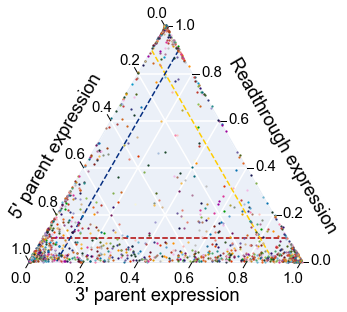

In [186]:
c_dict, order = get_biosample_colors()

_ = plot_simplex(rt_gids,hue='sample',
        cmap=c_dict,
        log_size=True,
        sectors=True,
        legend=False,
        jitter=True,
        size_scale=0.5,
        sect_alpha=0.1,
        sect_beta=0.1,
        sect_gamma=0.1,
        fname='figures/rt_summary_simplex.pdf')

In [187]:
# plot_thing(rt_gids)

In [188]:
def get_rt_sector_colors(cats=None):
    yellow = '#ffcc00'
    blue = '#052e81'
    red = '#b10000'
    orange = '#D86600'
    purple = '#5B1741'
    green = '#827D41'
    
    c_dict = {'rt_3': yellow,
              '5': purple,
              '3': orange,
              'rt': green,
              '5_3': red,
              'rt_5': blue,
             'mixed': 'gray'}
    order = ['5', 'rt_5', 'rt', 'rt_3', '3', '5_3', 'mixed']

    # c_dict, order = rm_color_cats(c_dict, order, cats)
    return c_dict, order

In [189]:
def assign_rt_sector(df, rt_prop=0.5, parent_3_prop=0.5, parent_5_prop=0.5):
    """
    Assign each gene triplet a sector that reflects its behavior

    Parameters:
        df (pandas DataFrame): DataFrame with simplex coordinates and n_iso

    Returns:
        df (pandas DataFrame): DataFrame with sector listed
    """
    # 7 sectors
    # mixed
    df['sector'] = 'mixed'
    
    # 5' / RT
    df.loc[(df.gene_tpm_prop>rt_prop)&\
       (df.gene_tpm_parent_5_prop>parent_5_prop)&\
       (df.gene_tpm_parent_3_prop<parent_3_prop), 'sector'] = 'rt_5'
    # 5' dominant
    df.loc[(df.gene_tpm_parent_3_prop<parent_3_prop)&\
       (df.gene_tpm_parent_5_prop>1-(rt_prop+parent_3_prop))&\
       (df.gene_tpm_prop<rt_prop), 'sector'] = '5'
    # 3' / RT
    df.loc[(df.gene_tpm_prop>rt_prop)&\
       (df.gene_tpm_parent_5_prop<parent_5_prop)&\
       (df.gene_tpm_parent_3_prop>parent_3_prop), 'sector'] = 'rt_3'
    # 3' dominant
    df.loc[(df.gene_tpm_parent_3_prop>1-(rt_prop+parent_5_prop))&\
       (df.gene_tpm_parent_5_prop<parent_5_prop)&\
       (df.gene_tpm_prop<rt_prop), 'sector'] = '3'
    # 5' / 3' 
    df.loc[(df.gene_tpm_prop<rt_prop)&\
       (df.gene_tpm_parent_5_prop>parent_5_prop)&\
       (df.gene_tpm_parent_3_prop>parent_3_prop), 'sector'] = '5_3'
    # RT dominant
    df.loc[(df.gene_tpm_parent_3_prop<parent_3_prop)&\
       (df.gene_tpm_parent_5_prop<parent_5_prop)&\
       (df.gene_tpm_prop>1-(parent_3_prop+parent_5_prop)), 'sector'] = 'rt'

    
    return df
# def assign_sector(df):
#     """
#     Assign each gene triplet a sector that reflects its behavior

#     Parameters:
#         df (pandas DataFrame): DataFrame with simplex coordinates and n_iso

#     Returns:
#         df (pandas DataFrame): DataFrame with sector listed
#     """
#     df['sector'] = 'simple'

#     df.loc[df.gene_tpm_prop > 0.5, 'sector'] = 'rt'
#     df.loc[df.gene_tpm_parent_3_prop > 0.5, 'sector'] = '3_parent'
#     df.loc[df.gene_tpm_parent_5_prop > 0.5, 'sector'] = '5_parent'

#     return df

In [190]:
rt_gids = assign_rt_sector(rt_gids, 0.1, 0.1, 0.1)

In [191]:
temp = rt_gids[['gene_id', 'sector']].groupby('sector').count().reset_index()
temp['tot'] = temp['gene_id'].sum(axis=0)
temp['perc'] = (temp['gene_id']/temp['tot'])*100
temp

,sector,gene_id,tot,perc
0,3,196,1750,11.200000
1,5,445,1750,25.428571
2,5_3,372,1750,21.257143
3,mixed,126,1750,7.200000
4,rt,315,1750,18.000000
5,rt_3,89,1750,5.085714
6,rt_5,207,1750,11.828571


In [192]:
c_dict, order = get_rt_sector_colors()

In [193]:
hr_labels = {'5': "5'-dominant",
             '3': "3'-dominant",
             'rt':'RT-dominant',
             'rt_5': "3'-depleted",
             'rt_3': "5'-depleted",
             '5_3': 'RT-depleted',
             'mixed': 'Mixed'}
temp['hr'] = temp.sector.map(hr_labels)

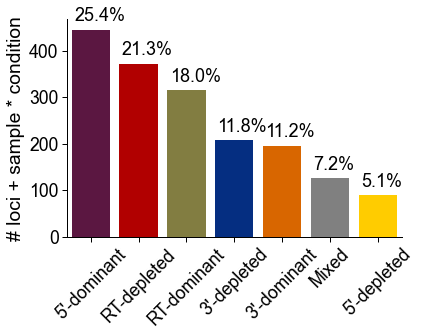

In [194]:
sns.set_context('paper', font_scale=2)
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42
order = temp.sort_values(by='gene_id', ascending=False).sector.tolist()
ax = sns.barplot(temp, y='gene_id', x='sector', palette=c_dict, saturation=1, order=order)
ax.set(xlabel='', ylabel='# loci + sample * condition')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
labels = [hr_labels[item.get_text()] for item in ax.get_xticklabels()]
_ = ax.set_xticklabels(labels)
ax.tick_params(axis="x", rotation=45)

def add_perc_2(ax, df):
    ylim = ax.get_ylim()[1]
    n_cats = len(ax.patches)
    for p in ax.patches:
        perc = p.get_height()
        tot = df.loc[df.gene_id==perc, 'perc'].values[0]
        x = p.get_x() + p.get_width() / 2 - (0.05)*n_cats
        y = p.get_y() + p.get_height() + ylim*0.04
        ax.annotate(f'{tot:.1f}%', (x, y), size = 18)

# a = ax.axes[0,0]
add_perc_2(ax, temp)
plt.savefig('figures/rt_gene_sample_per_sector.pdf', bbox_inches='tight')

In [197]:
rt_gids['novelty'] = 'Known'
rt_gids.loc[rt_gids.gene_id.str.contains('TALON'), 'novelty'] = 'Novel'
rt_gids.head()

,Unnamed: 0,gene_id,gene_id_parent_5,gene_id_parent_3,gid,sample,gene_tpm,gene_tpm_parent_5,gene_tpm_parent_3,total_tpm,gene_tpm_parent_5_prop,gene_tpm_prop,gene_tpm_parent_3_prop,sector,novelty
0,0,ENSG00000120948,ENSG00000277726,ENSG00000271895,ENSG00000120948,a673,225.837279,0.0,0.000000,225.837279,0.0,1.000000,0.000000,rt,Known
1,0,ENSG00000120948,ENSG00000277726,ENSG00000271895,ENSG00000120948,adipose,95.383761,0.0,0.000000,95.383761,0.0,1.000000,0.000000,rt,Known
2,0,ENSG00000120948,ENSG00000277726,ENSG00000271895,ENSG00000120948,adrenal_gland,46.309262,0.0,2.836603,49.145865,0.0,0.942282,0.057718,rt,Known
3,0,ENSG00000120948,ENSG00000277726,ENSG00000271895,ENSG00000120948,brain,59.097716,0.0,3.662926,62.760642,0.0,0.941637,0.058363,rt,Known
4,0,ENSG00000120948,ENSG00000277726,ENSG00000271895,ENSG00000120948,brain_ad,72.882712,0.0,2.967347,75.850059,0.0,0.960879,0.039121,rt,Known


<Figure size 576x432 with 0 Axes>

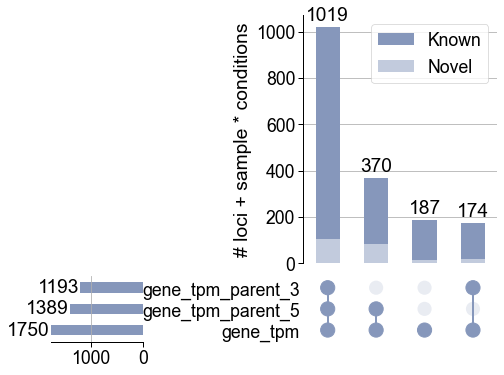

In [242]:
c_dict, order = get_gene_nov_colors()
c = c_dict['Fusion']
c_dict_2, order_2 = get_shade_colors(c, ['Known', 'Novel'])
c_dict_2

fig = plt.figure(figsize=(8,6))
det = rt_gids.set_index('gene_id')
det = det[['gene_tpm', 'gene_tpm_parent_5', 'gene_tpm_parent_3']]>0
det.reset_index(inplace=True)
det = det.merge(rt_gids[['gene_id', 'novelty']].drop_duplicates(), how='left', on='gene_id')
# det = det.groupby(['gene_tpm', 'gene_tpm_parent_5', 'gene_tpm_parent_3', 'novelty']).count()
det.set_index(['gene_tpm', 'gene_tpm_parent_5', 'gene_tpm_parent_3'], inplace=True)
fig = plt.figure(figsize=(8,6))
# upset = Upset(det, subset_size='auto',
#                 show_counts='%d', sort_by='cardinality',
#                shading_color='white', fig=fig, element_size=None, facecolor=c)
m = {'Known': 2, 'Novel': 1}
det['thing'] = det.novelty.map(m)
det.sort_values(by='thing', ascending=False)
upset = UpSet(det,
              subset_size='auto',
                show_counts='%d', sort_by='cardinality',
               shading_color='white', element_size=None, facecolor=c,
              intersection_plot_elements=0)  # disable the default bar chart
upset.add_stacked_bars(
    by="novelty", colors=c_dict_2, title='# loci + sample * conditions', elements=10
)
upset.plot(fig=fig)
plt.savefig('figures/rt_expression.pdf', bbox_inches='tight')

In [237]:
# # what % have expression of just one or btoh
# fig = plt.figure(figsize=(8,6))
# c_dict, order = get_gene_nov_colors(cats=None)
# c = c_dict['Fusion']
# rt_gids.head()
# det = rt_gids[['gene_tpm', 'gene_tpm_parent_5', 'gene_tpm_parent_3']]>0
# det['counts'] = 0
# det = det.groupby(['gene_tpm', 'gene_tpm_parent_5', 'gene_tpm_parent_3']).count()
# det = det.squeeze()
# upsetplot.plot(det, subset_size='auto',
#                 show_counts='%d', sort_by='cardinality',
#                shading_color='white', fig=fig, element_size=None, facecolor=c)
# plt.savefig('figures/rt_expression.pdf', bbox_inches='tight')

In [163]:
print(f'{(1019/(1019+370+187+174))*100}% of RT loci * samples have expression of 5, 3 and rt')

58.22857142857143% of RT loci * samples have expression of 5, 3 and rt


rt
5_3
5
rt_5
3
mixed
rt_3


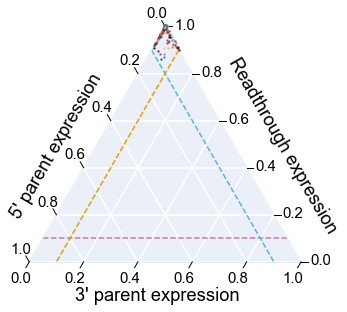

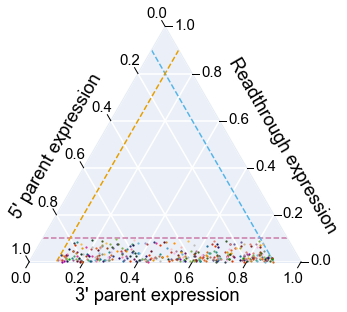

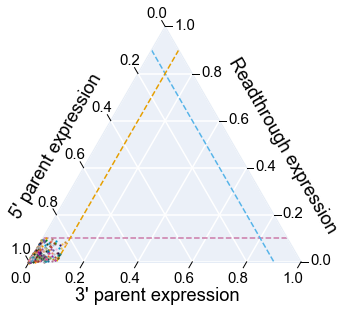

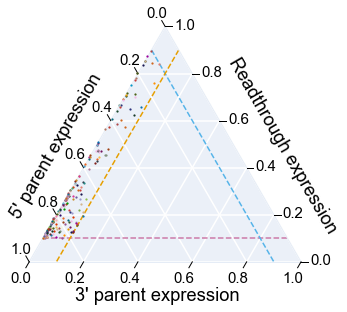

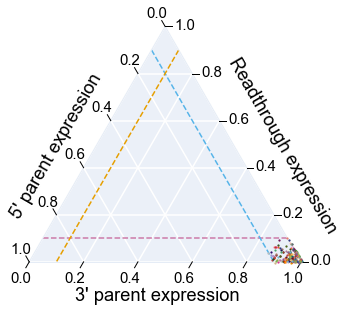

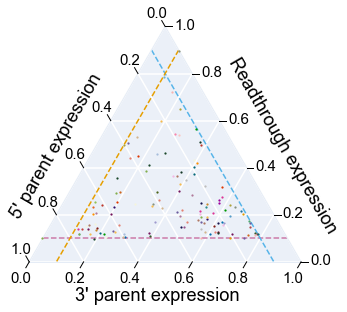

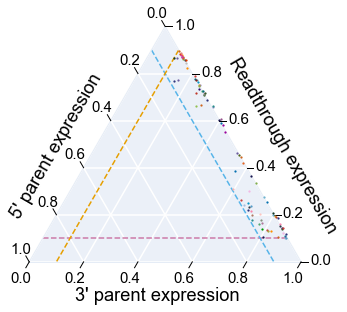

In [45]:
# make sure these sectors are right
c_dict, order = get_biosample_colors()
for s in rt_gids.sector.unique():
    temp = rt_gids.loc[rt_gids.sector == s].copy(deep=True)
    print(s)
    _ = plot_simplex(temp,
            hue='sample',
            cmap=c_dict,
            log_size=True,
            sectors=True,
            legend=False,
            jitter=True,
            size_scale=0.5,
            sect_alpha=0.1,
            sect_beta=0.1,
            sect_gamma=0.1,
            fname='figures/temp_simplex.pdf')
    

In [123]:
n = len(rt_gids.index)
n_num = len(rt_gids.loc[(rt_gids.gene_tpm_parent_3==0)|\
                        (rt_gids.gene_tpm_parent_5==0)].index)
print(f'{perc(n_num, n):.2f}% ({n_num}/{n}) of RT gene * sample pairs have one parent w/ 0 expression')

41.77% (731/1750) of RT gene * sample pairs have one parent w/ 0 expression


In [59]:
rt_gids.sort_values(by=['gene_tpm_prop', 'gene_tpm'], ascending=[False, False]).head(140).tail(10)

,Unnamed: 0,gene_id,gene_id_parent_5,gene_id_parent_3,gid,sample,gene_tpm,gene_tpm_parent_5,gene_tpm_parent_3,total_tpm,gene_tpm_parent_5_prop,gene_tpm_prop,gene_tpm_parent_3_prop,sector
5814,7865,TALONG000077252,ENSG00000259977,ENSG00000147041,TALONG000077252,a673,3.881849,0.0,0.0,3.881849,0.0,1.0,0.0,rt
2422,3322,ENSG00000214719,ENSG00000248121,ENSG00000250462,ENSG00000214719,hl60_m1_24hr,3.855167,0.0,0.0,3.855167,0.0,1.0,0.0,rt
7663,3001,ENSG00000196696,ENSG00000255185,ENSG00000226232,ENSG00000196696,h9_de,3.561216,0.0,0.0,3.561216,0.0,1.0,0.0,rt
8923,4773,ENSG00000285793,ENSG00000266931,ENSG00000231259,ENSG00000285793,vessels,3.276640,0.0,0.0,3.276640,0.0,1.0,0.0,rt
7667,3001,ENSG00000196696,ENSG00000255185,ENSG00000226232,ENSG00000196696,h9_panc_progen,3.041250,0.0,0.0,3.041250,0.0,1.0,0.0,rt
3558,4538,ENSG00000282304,ENSG00000261760,ENSG00000282785,ENSG00000282304,muscle,2.890064,0.0,0.0,2.890064,0.0,1.0,0.0,rt
8877,4773,ENSG00000285793,ENSG00000266931,ENSG00000231259,ENSG00000285793,brain,2.878767,0.0,0.0,2.878767,0.0,1.0,0.0,rt
9572,5873,ENSG00000164162,ENSG00000285713,ENSG00000285783,ENSG00000164162,liver,2.860450,0.0,0.0,2.860450,0.0,1.0,0.0,rt
4577,5618,ENSG00000283154,ENSG00000214216,ENSG00000151967,ENSG00000283154,mcf7,2.830987,0.0,0.0,2.830987,0.0,1.0,0.0,rt
7664,3001,ENSG00000196696,ENSG00000255185,ENSG00000226232,ENSG00000196696,h9_neural_crest,2.511115,0.0,0.0,2.511115,0.0,1.0,0.0,rt


In [60]:
# # ENSG00000285793
# rt_sj_df.loc[(rt_sj_df.gene_id=='ENSG00000285793')&\
#              (rt_sj_df.gene_id_parent=='ENSG00000266931')][['Chromosome_parent', 'Start_parent', 'End_parent']]

In [61]:
# rt_sj_df.loc[(rt_sj_df.gene_id=='ENSG00000120948')&\
#              (rt_sj_df.gene_id_parent=='ENSG00000271895')][['Chromosome_parent', 'Start_parent', 'End_parent']]

In [62]:
rt_gids.to_csv('rt_gids_simplex_coords.tsv', sep='\t', index=False)

## Get the variance of each tthing w/i genes

In [84]:
df = pd.read_csv('rt_gids_simplex_coords.tsv', sep='\t')
df.head()

,Unnamed: 0,gene_id,gene_id_parent_5,gene_id_parent_3,gid,sample,gene_tpm,gene_tpm_parent_5,gene_tpm_parent_3,total_tpm,gene_tpm_parent_5_prop,gene_tpm_prop,gene_tpm_parent_3_prop,sector
0,0,ENSG00000120948,ENSG00000277726,ENSG00000271895,ENSG00000120948,a673,225.837279,0.0,0.000000,225.837279,0.0,1.000000,0.000000,rt
1,0,ENSG00000120948,ENSG00000277726,ENSG00000271895,ENSG00000120948,adipose,95.383761,0.0,0.000000,95.383761,0.0,1.000000,0.000000,rt
2,0,ENSG00000120948,ENSG00000277726,ENSG00000271895,ENSG00000120948,adrenal_gland,46.309262,0.0,2.836603,49.145865,0.0,0.942282,0.057718,rt
3,0,ENSG00000120948,ENSG00000277726,ENSG00000271895,ENSG00000120948,brain,59.097716,0.0,3.662926,62.760642,0.0,0.941637,0.058363,rt
4,0,ENSG00000120948,ENSG00000277726,ENSG00000271895,ENSG00000120948,brain_ad,72.882712,0.0,2.967347,75.850059,0.0,0.960879,0.039121,rt


In [85]:
gtf_df, _, _ = get_gtf_info(how='gene', ver='v40_cerberus', add_stable_gid=True)
gtf_df.head()
df = df.merge(gtf_df[['gid_stable', 'gname']],
              how='left',
              left_on='gene_id', 
              right_on='gid_stable')

In [86]:
df = df.merge(df[['gene_id','gene_tpm_prop', 'gene_tpm_parent_5_prop', 'gene_tpm_parent_3_prop']].groupby('gene_id').mean().reset_index(),
              how='left',
              on='gene_id',
              suffixes=('','_centroid'))

In [87]:
df = df.merge(df[['gene_id','gene_tpm_prop', 'gene_tpm_parent_5_prop', 'gene_tpm_parent_3_prop']].groupby('gene_id').var().reset_index(),
              how='left',
              on='gene_id',
              suffixes=('','_var'))

In [88]:
df = df.merge(df[['gene_id', 'sample']].groupby('gene_id').nunique().reset_index().rename({'sample':'n_samples'},axis=1),
              how='left',
              on='gene_id')

In [89]:
df.sort_values(by='n_samples', ascending=False).head()

,Unnamed: 0,gene_id,gene_id_parent_5,gene_id_parent_3,gid,sample,gene_tpm,gene_tpm_parent_5,gene_tpm_parent_3,total_tpm,...,sector,gid_stable,gname,gene_tpm_prop_centroid,gene_tpm_parent_5_prop_centroid,gene_tpm_parent_3_prop_centroid,gene_tpm_prop_var,gene_tpm_parent_5_prop_var,gene_tpm_parent_3_prop_var,n_samples
0,0,ENSG00000120948,ENSG00000277726,ENSG00000271895,ENSG00000120948,a673,225.837279,0.000000,0.000000,225.837279,...,rt,ENSG00000120948,TARDBP,0.992797,0.000000,0.007203,0.000195,0.000000,0.000195,51
244,2770,ENSG00000213599,ENSG00000132207,ENSG00000261052,ENSG00000213599,adipose,5.020198,29.284488,6.693597,40.998283,...,5_parent,ENSG00000213599,SLX1A-SULT1A3,0.207722,0.715507,0.076771,0.023547,0.034238,0.012282,51
251,2770,ENSG00000213599,ENSG00000132207,ENSG00000261052,ENSG00000213599,gm12878,1.691106,47.217639,0.000000,48.908744,...,5_parent,ENSG00000213599,SLX1A-SULT1A3,0.207722,0.715507,0.076771,0.023547,0.034238,0.012282,51
250,2770,ENSG00000213599,ENSG00000132207,ENSG00000261052,ENSG00000213599,colon,9.234797,99.099516,40.915628,149.249940,...,5_parent,ENSG00000213599,SLX1A-SULT1A3,0.207722,0.715507,0.076771,0.023547,0.034238,0.012282,51
249,2770,ENSG00000213599,ENSG00000132207,ENSG00000261052,ENSG00000213599,calu3,9.459821,105.354313,6.365006,121.179140,...,5_parent,ENSG00000213599,SLX1A-SULT1A3,0.207722,0.715507,0.076771,0.023547,0.034238,0.012282,51


In [90]:
# df.loc[df.gene_id=='ENSG00000213599']

In [91]:
df['max_var'] = df[['gene_tpm_prop_var', 'gene_tpm_parent_5_prop_var', 'gene_tpm_parent_3_prop_var']].max(axis=1)

In [92]:
df.to_csv('temp_rt_genes_w_max_var.tsv', sep='\t')

In [93]:
# import pandas as pd
# import numpy as np
# import scipy.stats as st
# import seaborn as sns
# import sys
# import os
# import gseapy as gp
# import matplotlib.pyplot as plt
# import swan_vis as swan
# import yaml
# from snakemake.io import expand
# import pyranges as pr

# p = os.path.dirname(os.path.dirname(os.getcwd()))
# sys.path.append(p)

# from proc_revisions.utils import *
# from proc_revisions.plotting import *
# from proc_revisions.ss_sj_utils import *
# from proc_revisions.extra_simplex_plots import *

# od = '../../proc_revisions/'
# config_file = f'{od}/config.yml'
# with open(config_file) as f:
#     config = yaml.safe_load(f)
    
# species = 'human'
# ab = od+expand(config['lr']['talon']['fusion_fix']['ab'], species='human')[0]
# filt_ab = od+expand(config['lr']['cerberus']['filt_ab'], species=species)[0]
# gtf = od+expand(config['lr']['cerberus']['gtf'], species=species)[0]
# lib_meta = od+expand(config['lr']['meta'], species=species)[0]
# cerberus_h5 = od+expand(config['lr']['cerberus']['ca_triplets'], species=species, obs_col='sample')[0]
# swan_file = od+expand(config['lr']['swan']['sg'], species=species)[0]
# ref_gtf = od+expand(config['ref']['new_gtf'], species=species)[0]
# pp_summary = od+expand(config['lr']['protein_pred']['summary'], species='human')[0]
# gtf_file = od+expand(config['lr']['cerberus']['gtf'], species='human')[0]

# gtex_gtf_file = od+expand(config['gtex']['gtf'], species='human')[0]

# gene_subset = 'polya'
# min_tpm = 1

# species = 'mouse'
# m_filt_ab = od+expand(config['lr']['cerberus']['filt_ab'], species=species)[0]
# m_gtf = od+expand(config['lr']['cerberus']['gtf'], species=species)[0]
# m_lib_meta = od+expand(config['lr']['meta'], species=species)[0]
# m_cerberus_h5 = od+expand(config['lr']['cerberus']['ca_triplets'], species=species, obs_col='sample')[0]
# m_swan_file = od+expand(config['lr']['swan']['sg'], species=species)[0]
# m_ref_gtf = od+expand(config['ref']['new_gtf'], species=species)[0]

# def assign_rt_sector(df, rt_prop=0.5, parent_3_prop=0.5, parent_5_prop=0.5):
#     """
#     Assign each gene triplet a sector that reflects its behavior

#     Parameters:
#         df (pandas DataFrame): DataFrame with simplex coordinates and n_iso

#     Returns:
#         df (pandas DataFrame): DataFrame with sector listed
#     """
#     df['sector'] = 'simple'

#     df.loc[df.gene_tpm_prop < rt_prop, 'sector'] = 'rt_low'
#     df.loc[df.gene_tpm_parent_3_prop < parent_3_prop, 'sector'] = '3_parent_lo'
#     df.loc[df.gene_tpm_parent_5_prop < parent_5_prop, 'sector'] = '5_parent_lo'

#     return df

In [94]:
df = pd.read_csv('temp_rt_genes_w_max_var.tsv', sep='\t')
df = assign_rt_sector(df, rt_prop=0.1,
                      parent_3_prop=0.1,
                      parent_5_prop=0.1)

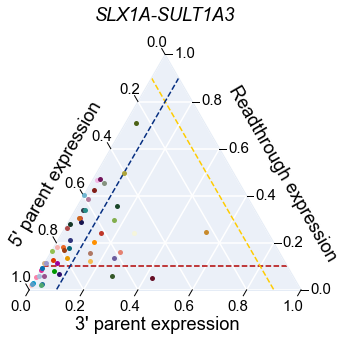

In [95]:
gid = 'SLX1A-SULT1A3'
temp = df.loc[df.gname==gid]
c_dict, order = get_biosample_colors()
temp

# plot_thing(temp)
_ = plot_simplex(temp,
        gene=gid,
        hue='sample',
        cmap=c_dict,
        log_size=True,
        sectors=True,
        legend=False,
        jitter=True,
        size_scale=0.5,
        sect_alpha=0.1,
        sect_beta=0.1,
        sect_gamma=0.1,
        fname=f'figures/rt_{gid}_simplex.pdf')

In [96]:
# what % of RT loci have each at least 80% of their sample triplets in the same sector?
# make sure that we're only looking at RT loci in at least two samples
min_perc = 80
min_samp = 5
temp = df.loc[df.n_samples>=min_samp].copy(deep=True)
# print(temp.loc[temp.gname=='SLX1A-SULT1A3'][['sector', 'sample']].groupby('sector').nunique())
temp = temp[['sector', 'gname', 'sample']].groupby(['sector', 'gname']).count().reset_index().rename({'sample':'n_sample_sect'}, axis=1)
temp = temp.merge(temp[['gname', 'n_sample_sect']].groupby('gname').sum().reset_index().rename({'n_sample_sect':'n_sample_tot'}, axis=1),
                  how='left',
                  on='gname')
temp['perc'] = (temp['n_sample_sect']/temp['n_sample_tot'])*100
n = len(temp.gname.unique().tolist())
n_num = len(temp.loc[temp.perc>=min_perc].gname.unique().tolist())
print(f'{perc(n_num,n):.2f}% ({n_num}/{n}) 2-parent RT genes expressed in >{min_samp} have {min_perc}% of their samples in the same sector')


51.39% (37/72) 2-parent RT genes expressed in >5 have 80% of their samples in the same sector


In [97]:
# what do genes that dont' behave like this look like?
temp.loc[temp.perc<min_perc].head()

,sector,gname,n_sample_sect,n_sample_tot,perc
0,3,ARPIN-AP3S2,20,33,60.606061
1,3,BCL2L2-PABPN1,5,9,55.555556
2,3,BIVM-ERCC5,4,49,8.163265
3,3,BLOC1S5-TXNDC5,2,5,40.000000
4,3,CCL15-CCL14,2,7,28.571429


In [100]:
temp.head()

,sector,gname,n_sample_sect,n_sample_tot,perc
0,3,ARPIN-AP3S2,20,33,60.606061
1,3,BCL2L2-PABPN1,5,9,55.555556
2,3,BIVM-ERCC5,4,49,8.163265
3,3,BLOC1S5-TXNDC5,2,5,40.000000
4,3,CCL15-CCL14,2,7,28.571429


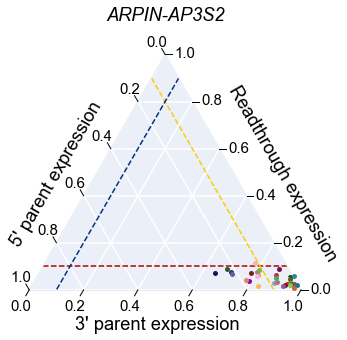

In [101]:
gid = 'ARPIN-AP3S2'
temp = df.loc[df.gname==gid]

c_dict, order = get_biosample_colors()
# plot_thing(temp)
_ = plot_simplex(temp,
        gene=gid,
        hue='sample',
        cmap=c_dict,
        log_size=True,
        sectors=True,
        legend=False,
        jitter=True,
        size_scale=0.5,
        sect_alpha=0.1,
        sect_beta=0.1,
        sect_gamma=0.1,
        fname=f'figures/rt_{gid}_simplex.pdf')

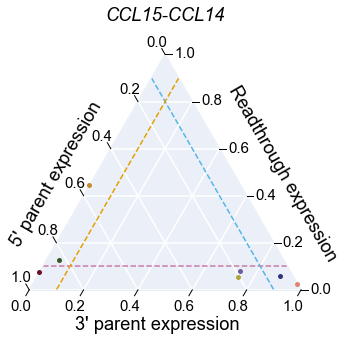

In [30]:
gid = 'CCL15-CCL14'
temp = df.loc[df.gname==gid]
c_dict, order = get_biosample_colors()
temp

# plot_thing(temp)
_ = plot_simplex(temp,
        gene=gid,
        hue='sample',
        cmap=c_dict,
        log_size=True,
        sectors=True,
        legend=False,
        jitter=True,
        size_scale=0.5,
        sect_alpha=0.1,
        sect_beta=0.1,
        sect_gamma=0.1,
        fname=f'figures/rt_{gid}_simplex.pdf')

In [9]:
# limit the results to those expressed in a min number of samples at a min tpm
min_tpm_2 = 5
min_samples = 5
df['max_tpm'] = df[['gene_tpm', 'gene_tpm_parent_5', 'gene_tpm_parent_3']].max(axis=1)
df.loc[(df.n_samples>=min_samples)&(df.max_tpm>=min_tpm_2)].sort_values('max_var', ascending=False).head(50).tail(10)
# df.sort_values('max_var', ascending=False).head()

,Unnamed: 0,Unnamed: 0.1,gene_id,gene_id_parent_5,gene_id_parent_3,gid,sample,gene_tpm,gene_tpm_parent_5,gene_tpm_parent_3,...,gname,gene_tpm_prop_centroid,gene_tpm_parent_5_prop_centroid,gene_tpm_parent_3_prop_centroid,gene_tpm_prop_var,gene_tpm_parent_5_prop_var,gene_tpm_parent_3_prop_var,n_samples,max_var,max_tpm
705,705,5618,ENSG00000283154,ENSG00000214216,ENSG00000151967,ENSG00000283154,hffc6,10.272569,0.000000,0.000000,...,IQCJ-SCHIP1,0.657918,0.000021,0.34206,0.1212,1.367167e-08,0.121177,30,0.1212,10.272569
704,704,5618,ENSG00000283154,ENSG00000214216,ENSG00000151967,ENSG00000283154,heart,21.956687,0.000000,93.553036,...,IQCJ-SCHIP1,0.657918,0.000021,0.34206,0.1212,1.367167e-08,0.121177,30,0.1212,93.553036
703,703,5618,ENSG00000283154,ENSG00000214216,ENSG00000151967,ENSG00000283154,hct116,10.782334,0.000000,0.000000,...,IQCJ-SCHIP1,0.657918,0.000021,0.34206,0.1212,1.367167e-08,0.121177,30,0.1212,10.782334
702,702,5618,ENSG00000283154,ENSG00000214216,ENSG00000151967,ENSG00000283154,h9_chondro,49.774212,0.000000,14.776761,...,IQCJ-SCHIP1,0.657918,0.000021,0.34206,0.1212,1.367167e-08,0.121177,30,0.1212,49.774212
701,701,5618,ENSG00000283154,ENSG00000214216,ENSG00000151967,ENSG00000283154,h1_de,8.007625,0.000000,2.157334,...,IQCJ-SCHIP1,0.657918,0.000021,0.34206,0.1212,1.367167e-08,0.121177,30,0.1212,8.007625
700,700,5618,ENSG00000283154,ENSG00000214216,ENSG00000151967,ENSG00000283154,h1,12.235233,0.000000,16.867186,...,IQCJ-SCHIP1,0.657918,0.000021,0.34206,0.1212,1.367167e-08,0.121177,30,0.1212,16.867186
695,695,5618,ENSG00000283154,ENSG00000214216,ENSG00000151967,ENSG00000283154,brain,24.063239,0.000000,330.464868,...,IQCJ-SCHIP1,0.657918,0.000021,0.34206,0.1212,1.367167e-08,0.121177,30,0.1212,330.464868
696,696,5618,ENSG00000283154,ENSG00000214216,ENSG00000151967,ENSG00000283154,brain_ad,51.107645,0.263169,359.554271,...,IQCJ-SCHIP1,0.657918,0.000021,0.34206,0.1212,1.367167e-08,0.121177,30,0.1212,359.554271
697,697,5618,ENSG00000283154,ENSG00000214216,ENSG00000151967,ENSG00000283154,caco2,28.437559,0.000000,0.000000,...,IQCJ-SCHIP1,0.657918,0.000021,0.34206,0.1212,1.367167e-08,0.121177,30,0.1212,28.437559
698,698,5618,ENSG00000283154,ENSG00000214216,ENSG00000151967,ENSG00000283154,calu3,11.118050,0.000000,0.000000,...,IQCJ-SCHIP1,0.657918,0.000021,0.34206,0.1212,1.367167e-08,0.121177,30,0.1212,11.118050


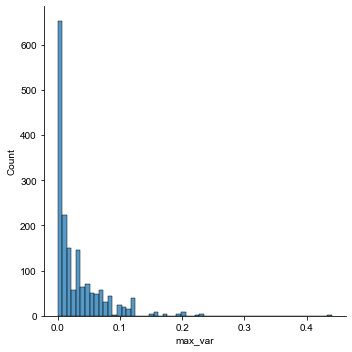

In [113]:
# what's the distribution of max variance look like?
temp = df.loc[df.n_samples>=2]
sns.displot(temp, x='max_var', kind='hist')

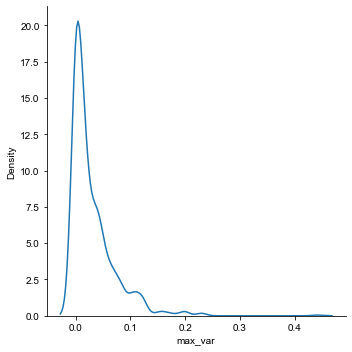

In [127]:
# what's the distribution of max variance look like?
temp = df.loc[df.n_samples>=2]
sns.displot(temp, x='max_var', kind='kde')

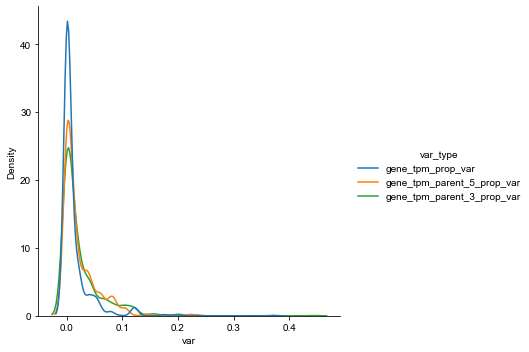

In [136]:
temp =  df[['gene_tpm_prop_var', 'gene_tpm_parent_5_prop_var', 'gene_tpm_parent_3_prop_var', 'gid']]
temp = temp.set_index('gid')
temp = temp.melt(value_name='var', var_name='var_type', ignore_index=False).reset_index()
sns.displot(temp, x='var', hue='var_type', kind='kde', common_norm=False)

In [114]:
df.loc[(df.n_samples>=2)&(df.max_var<0.25)].head()

,Unnamed: 0,gene_id,gene_id_parent_5,gene_id_parent_3,gid,sample,gene_tpm,gene_tpm_parent_5,gene_tpm_parent_3,total_tpm,...,sector,gene_tpm_prop_centroid,gene_tpm_parent_5_prop_centroid,gene_tpm_parent_3_prop_centroid,gene_tpm_prop_var,gene_tpm_parent_5_prop_var,gene_tpm_parent_3_prop_var,n_samples,max_var,max_tpm
0,0,ENSG00000120948,ENSG00000277726,ENSG00000271895,ENSG00000120948,a673,225.837279,0.0,0.000000,225.837279,...,rt,0.992797,0.0,0.007203,0.000195,0.0,0.000195,51,0.000195,225.837279
1,0,ENSG00000120948,ENSG00000277726,ENSG00000271895,ENSG00000120948,adipose,95.383761,0.0,0.000000,95.383761,...,rt,0.992797,0.0,0.007203,0.000195,0.0,0.000195,51,0.000195,95.383761
2,0,ENSG00000120948,ENSG00000277726,ENSG00000271895,ENSG00000120948,adrenal_gland,46.309262,0.0,2.836603,49.145865,...,rt,0.992797,0.0,0.007203,0.000195,0.0,0.000195,51,0.000195,46.309262
3,0,ENSG00000120948,ENSG00000277726,ENSG00000271895,ENSG00000120948,brain,59.097716,0.0,3.662926,62.760642,...,rt,0.992797,0.0,0.007203,0.000195,0.0,0.000195,51,0.000195,59.097716
4,0,ENSG00000120948,ENSG00000277726,ENSG00000271895,ENSG00000120948,brain_ad,72.882712,0.0,2.967347,75.850059,...,rt,0.992797,0.0,0.007203,0.000195,0.0,0.000195,51,0.000195,72.882712


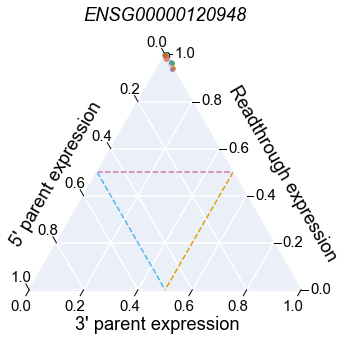

In [115]:
gid = 'ENSG00000120948'
temp = df.loc[df.gene_id==gid]
c_dict, order = get_biosample_colors()

# plot_thing(temp)
_ = plot_simplex(temp,
        gene=gid,
        hue='sample',
        cmap=c_dict,
        log_size=True,
        sectors=True,
        legend=False,
        jitter=True,
        size_scale=0.5,
        fname=f'figures/rt_{gid}_simplex.pdf')

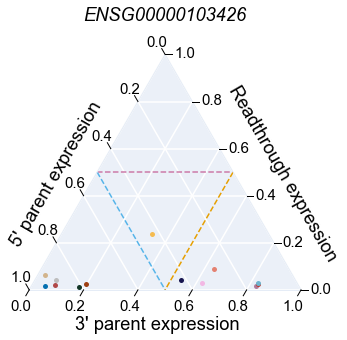

In [108]:
gid = 'ENSG00000103426'
temp = df.loc[df.gene_id==gid]
c_dict, order = get_biosample_colors()

# plot_thing(temp)
_ = plot_simplex(temp,
        gene=gid,
        hue='sample',
        cmap=c_dict,
        log_size=True,
        sectors=True,
        legend=False,
        jitter=True,
        size_scale=0.5,
        fname=f'figures/rt_{gid}_simplex.pdf')

In [109]:
df.loc[df.gene_id=='ENSG00000103426'].sort_values(by='gene_tpm_parent_3_prop', ascending=False)[['gene_tpm_prop', 'gene_tpm_parent_5_prop', 'gene_tpm_parent_3_prop', 'sample']]

,gene_tpm_prop,gene_tpm_parent_5_prop,gene_tpm_parent_3_prop,sample
1150,0.027881,0.141197,0.830922,heart
1146,0.015697,0.159425,0.824878,brain
1156,0.029412,0.147059,0.823529,panc1
1157,0.091906,0.273099,0.634994,vessels
1147,0.029097,0.347734,0.623168,brain_ad
1155,0.044301,0.420306,0.535393,ovary
1145,0.238095,0.428571,0.333333,adipose
1148,0.028269,0.775165,0.196566,h9
1154,0.012752,0.812321,0.174927,ocily7
1149,0.019739,0.895530,0.084731,h9_de


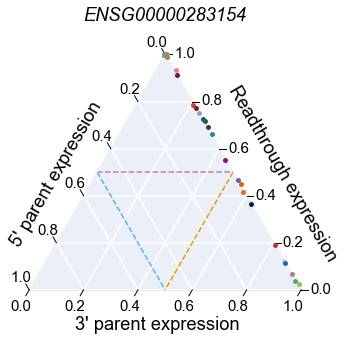

In [93]:
gid = 'ENSG00000283154'
temp = df.loc[df.gene_id==gid]
c_dict, order = get_biosample_colors()

# plot_thing(temp)
_ = plot_simplex(temp,
        gene=gid,
        hue='sample',
        cmap=c_dict,
        log_size=True,
        sectors=True,
        legend=False,
        jitter=True,
        size_scale=0.5,
        fname=f'figures/rt_{gid}_simplex.pdf')

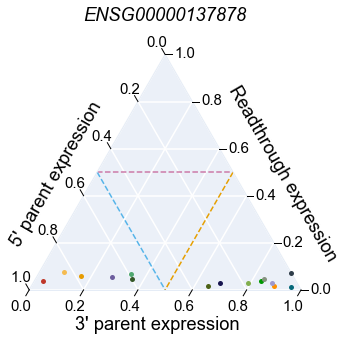

In [101]:
gid = 'ENSG00000137878'
temp = df.loc[df.gene_id==gid]
c_dict, order = get_biosample_colors()

# plot_thing(temp)
_ = plot_simplex(df,
        gene=gid,
        hue='sample',
        cmap=c_dict,
        log_size=True,
        sectors=True,
        legend=False,
        jitter=True,
        size_scale=0.5,
        fname=f'figures/rt_{gid}_simplex.pdf')

In [106]:
df.loc[df.gene_id=='ENSG00000137878'].sort_values(by='gene_tpm_parent_3_prop', ascending=False)[['gene_tpm_prop', 'gene_tpm_parent_5_prop', 'gene_tpm_parent_3_prop', 'sample']]

,gene_tpm_prop,gene_tpm_parent_5_prop,gene_tpm_parent_3_prop,sample
209,0.014713,0.029512,0.955775,mcf10a
210,0.075000,0.000000,0.925000,mcf7
201,0.016879,0.091126,0.891995,caco2
207,0.029394,0.093911,0.876696,hmec
212,0.046296,0.111111,0.842593,pc3
202,0.033936,0.128660,0.837404,calu3
205,0.028302,0.179245,0.792453,hct116
211,0.029412,0.284592,0.685997,ovary
204,0.018403,0.331332,0.650265,h9_panc_progen
203,0.047582,0.593688,0.358730,colon
